# Fine-Tuning PaliGemma with QVLA

#### Author: nisan yildiz

----

PaliGemma is a pre-trained VLM designed to be a efficient base model for various fine-tuning applications in VL domain. Here, we will be fine-tuning the PaliGemma pre-trained model for image annotation task using quantization and Adapters. Adapters are small layers that are "plugged-in" to the larger model during fine-tuning to be trained while rest of the architecture remains frozen. This allows efficient fine-tuning of base-models without the need to train the entire network.

In [1]:
!git clone https://github.com/adapter-hub/adapters.git
%cd adapters
!pip install .
!pip install -U bitsandbytes
!pip install -U datasets

Cloning into 'adapters'...
remote: Enumerating objects: 126942, done.
remote: Counting objects: 100% (584/584), done.
remote: Compressing objects: 100% (427/427), done.
remote: Total 126942 (delta 383), reused 204 (delta 156), pack-reused 126358 (from 2)
Receiving objects: 100% (126942/126942), 99.40 MiB | 13.32 MiB/s, done.
Resolving deltas: 100% (96629/96629), done.
/content/adapters
Processing /content/adapters
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.2/10.2 MB 99.0 MB/s eta 0:00:00
  Created wheel for adapters: filename=adapters-1.2.0.dev0-py3-none-any.whl size=302111 sha256=05e1cd4063fa9b59cc44d430d9c5500275c80ee675695759b8acf7c2d0e41b52
  Stored in directory: /tmp/pip-ephem-wheel-cache-8wuuvhnc/wheels/b4/1e/1c/33b15799190230021dbb3b427d2484d76e048d073058c04a71
Successfully built adapters
  Attempting uninstall: transformers
    Found existin

In [2]:
#Connect to drive
from google.colab import drive
drive.mount('/content/drive')

%cd /content/drive/MyDrive/DI725/DI725-project


Mounted at /content/drive
/content/drive/MyDrive/DI725/DI725-project


In [3]:
import adapters
from adapters import AdapterModelInterface

In [4]:
import torch
from torch import nn

from transformers import BitsAndBytesConfig
from transformers import AutoProcessor, AutoModel, PaliGemmaForConditionalGeneration, AutoConfig

from huggingface_hub import notebook_login

from datasets import load_dataset

import wandb

In [5]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model_id = "google/paligemma-3b-pt-224" # pt for pre-trained, needs fine-tuning

## Load the dataset

In [ ]:
#process the dataset into jsonl files from the given captions csv

#!python3 process_dataset.py

In [7]:
dataset = load_dataset("json", data_files={'train': 'RISCM/resized/train_data.jsonl', 'test':'RISCM/resized/test_data.jsonl', 'validation':"RISCM/resized/val_data.jsonl"})

Generating train split: 0 examples [00:00, ? examples/s]

Generating test split: 0 examples [00:00, ? examples/s]

Generating validation split: 0 examples [00:00, ? examples/s]

## Fine-tuning with quantization

In [8]:
#We need to log-in before using the PaliGemma model, as it is subject to agreement

notebook_login()

In [9]:
processor = AutoProcessor.from_pretrained(model_id)
config = AutoConfig.from_pretrained(model_id)

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


preprocessor_config.json:   0%|          | 0.00/699 [00:00<?, ?B/s]

Using a slow image processor as `use_fast` is unset and a slow processor was saved with this model. `use_fast=True` will be the default behavior in v4.52, even if the model was saved with a slow processor. This will result in minor differences in outputs. You'll still be able to use a slow processor with `use_fast=False`.


tokenizer_config.json:   0%|          | 0.00/40.0k [00:00<?, ?B/s]

tokenizer.model:   0%|          | 0.00/4.26M [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/17.5M [00:00<?, ?B/s]

added_tokens.json:   0%|          | 0.00/24.0 [00:00<?, ?B/s]

special_tokens_map.json:   0%|          | 0.00/607 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/1.03k [00:00<?, ?B/s]

In [10]:
from transformers.modeling_outputs import BaseModelOutputWithPooling
from adapters.heads import PredictionHead
# Create a custom model class by inheriting from the original model class

class IdentityHead(PredictionHead):
    def __init__(self):
        super().__init__(name="identity_head")
        self.config = {
            "layers": 1,
            "activation_function": None,
            "use_pooler": False,
            "dropout_prob": 0.0
        }
        self.identity = nn.Identity()
        # Add the identity module
        self.add_module("0", self.identity)

    def build(self, model):
        # Override build to do nothing since we just want identity functionality
        self.train(model.training)  # make sure training mode is consistent

    def forward(self, hidden_states, **kwargs):
        # Ensure we maintain the correct dimensions
        # hidden_states shape: [batch_size, seq_len, hidden_size] or [batch_size, hidden_size]

        # Check if we need to preserve dimensions
        original_shape = hidden_states.shape

        # Apply identity transformation (maintaining the original shape)
        output = super().forward(hidden_states)

        # Ensure output has the same shape as input
        if output.shape != original_shape:
            output = output.view(original_shape)

        return output

    def get_label_names(self):
        # Override to return the expected label names
        return ["labels"]

def dummy_save_all_heads(self, *args, **kwargs):
    # This dummy method does nothing, but prevents AttributeError during training.
    pass

### Adding VL-Adapter

PaliGemma model is not officially supported by the adapters library. We need to create a model interface object to be able to use it with adapters.

In [11]:
bottleneck_interface_lm = AdapterModelInterface(
    adapter_methods=["bottleneck"], # the vanilla Adapter a.k.a bottleneck adapter
    model_embeddings="language_model.model.embed_tokens",
    model_layers="language_model.model.layers",
    layer_self_attn="self_attn",
    layer_cross_attn=None,
    attn_k_proj="k_proj",
    attn_q_proj="q_proj",
    attn_v_proj="v_proj",
    attn_o_proj="o_proj",
    layer_intermediate_proj="mlp.up_proj",
    layer_output_proj="mlp.down_proj",
)

### Quantization

We will be using 4-bit quantization for our model, with the NF4 datatype. Computations will be done in 16-bit bfloat16 type. We are also double quantizing.  

In [12]:
from transformers import BitsAndBytesConfig

nf4_config = BitsAndBytesConfig(
   load_in_4bit=True,
   bnb_4bit_quant_type="nf4",
   bnb_4bit_compute_dtype=torch.bfloat16,
   bnb_4bit_use_double_quant=True)

base_NF4_model = PaliGemmaForConditionalGeneration.from_pretrained(model_id, quantization_config=nf4_config)
base_NF4_model.heads = nn.ModuleDict({"identity_head": IdentityHead()})
base_NF4_model.save_all_heads = dummy_save_all_heads.__get__(base_NF4_model)

#adding the adapter
adapters.init(base_NF4_model, interface=bottleneck_interface_lm)
base_NF4_model.add_adapter("adapter_lm", config="double_seq_bn")
base_NF4_model.set_active_adapters("adapter_lm")

#cast some layers to full precision
for param in base_NF4_model.parameters():
    if param.ndim == 1:
        # cast the small parameters (e.g. layernorm) to fp32 for stability
        param.data = param.data.to(torch.float32)

# Enable gradient checkpointing to reduce required memory
base_NF4_model.gradient_checkpointing_enable()
base_NF4_model.enable_input_require_grads()

class CastOutputToFloat(torch.nn.Sequential):
    def forward(self, x): return super().forward(x).to(torch.float32)
base_NF4_model.language_model.lm_head = CastOutputToFloat(base_NF4_model.language_model.lm_head)

#moving to device
base_NF4_model.to(device)
base_NF4_model.adapter_to("adapter_lm", device=device)



`low_cpu_mem_usage` was None, now default to True since model is quantized.


model.safetensors.index.json:   0%|          | 0.00/62.6k [00:00<?, ?B/s]

Fetching 3 files:   0%|          | 0/3 [00:00<?, ?it/s]

model-00003-of-00003.safetensors:   0%|          | 0.00/1.74G [00:00<?, ?B/s]

model-00001-of-00003.safetensors:   0%|          | 0.00/4.95G [00:00<?, ?B/s]

model-00002-of-00003.safetensors:   0%|          | 0.00/5.00G [00:00<?, ?B/s]

Loading checkpoint shards:   0%|          | 0/3 [00:00<?, ?it/s]

generation_config.json:   0%|          | 0.00/137 [00:00<?, ?B/s]

In [13]:
#Verifying the datatypes.
dtypes = {}
for _, p in base_NF4_model.named_parameters():
    dtype = p.dtype
    if dtype not in dtypes:
        dtypes[dtype] = 0
    dtypes[dtype] += p.numel()
total = 0
for k, v in dtypes.items():
    total += v
for k, v in dtypes.items():
    print(k, v, v / total)

torch.float16 527750656 0.3024705759052781
torch.float32 19430128 0.011136020276350484
torch.uint8 1197619200 0.6863934038183714


## Prepare dataset for training

RISCM dataset consists of captioned sattelite imagery with 5 captions provided per image. Our captions table includes information about all captions, as well as informations about the training/test/validation splits and the original source of the images.

In [14]:
image_dir = "RISCM/resized/"
from PIL import Image
import PIL
def collate_fn(examples):
      texts = [f"<image> <bos> {example['prefix']}" for example in examples]
      labels= [example['suffix'] for example in examples]
      images = [PIL.Image.open(image_dir + example["file_name"]).convert("RGB") for example in examples]
      tokens = processor(text=texts, images=images, suffix=labels,
      return_tensors="pt", padding="longest")
      tokens = tokens.to(torch.bfloat16).to(device)
      return tokens

### Fine-tuning the quantized model

#### wandb logging

In [15]:
wandb.init(
    project="paligemma-finetune",
    name="run_qvla_batch4_r2",
    config={
        "num_train_epochs": 2,
        "per_device_train_batch_size": 4,
        "gradient_accumulation_steps": 1,
        "learning_rate": 5e-4,
        "weight_decay": 1e-6,
        "adam_beta2": 0.999,
        "optim": "paged_adamw_8bit",
        "bf16": True,

    }
)

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize?ref=models
wandb: Paste an API key from your profile and hit enter:

 ··········


wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: No netrc file found, creating one.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc
wandb: Currently logged in as: yildizz-nisan (yildizz-nisan-middle-east-technical-university) to https://api.wandb.ai. Use `wandb login --relogin` to force relogin


In [16]:
from transformers import TrainingArguments, EarlyStoppingCallback
q_args=TrainingArguments(
            num_train_epochs=1,
            remove_unused_columns=False,
            per_device_train_batch_size=4,
            gradient_accumulation_steps=1,
            warmup_steps=2,
            learning_rate=5e-4,
            weight_decay=1e-6,
            adam_beta2=0.999,
            logging_steps=100,
            optim="paged_adamw_8bit", # you can use paged optimizers like paged_adamw_8bit for Q or adamw_hf
            save_strategy="steps",
            save_steps=1000,
            save_total_limit=10,
            output_dir="paligemma_qvla_r2",
            bf16=True,
            report_to=["wandb"],
            dataloader_pin_memory=False,
            eval_strategy="steps",
            eval_steps=1000,
            load_best_model_at_end=True,
            metric_for_best_model="eval_loss",
            greater_is_better=False,
        )


In [17]:
from adapters import AdapterTrainer

In [18]:
base_NF4_model.active_head = "identity_head"
base_NF4_model._active_heads = [base_NF4_model.active_head]
base_NF4_model.train_adapter("adapter_lm")

In [19]:
q_trainer = AdapterTrainer(
    model=base_NF4_model,
    train_dataset=dataset["train"],
    eval_dataset=dataset["validation"],
    #callbacks=[EarlyStoppingCallback(early_stopping_patience=3)],
    data_collator=collate_fn,
    args=q_args
)

q_trainer.train()

wandb: WARNING The `run_name` is currently set to the same value as `TrainingArguments.output_dir`. If this was not intended, please specify a different run name by setting the `TrainingArguments.run_name` parameter.
`use_cache=True` is incompatible with gradient checkpointing. Setting `use_cache=False`.


Step,Training Loss,Validation Loss
1000,1.396100,1.620057
2000,1.184300,1.461722
3000,1.064700,1.350548
4000,1.024600,1.260576
5000,0.957200,1.201092
6000,0.895900,1.155418
7000,0.849200,1.108819
8000,0.758000,1.070018


TrainOutput(global_step=8904, training_loss=1.0438663235464722, metrics={'train_runtime': 34972.3553, 'train_samples_per_second': 1.018, 'train_steps_per_second': 0.255, 'total_flos': 1.4463050695340813e+17, 'train_loss': 1.0438663235464722, 'epoch': 1.0})

In [24]:
base_NF4_model.save_adapter(save_directory="paligemma_qvla_r2/final", adapter_name="adapter_lm")

## Inference

In [32]:
input_text = f"<image> <bos> {dataset['test'][0]['prefix']}"
input_image = PIL.Image.open(image_dir + dataset["test"][0]["file_name"])

In [33]:
inputs = processor(text=input_text, images=input_image,
                  padding="longest", do_convert_rgb=True, return_tensors="pt").to(device)

In [37]:
dataset["test"]

Dataset({
    features: ['file_name', 'prefix', 'suffix'],
    num_rows: 4454
})

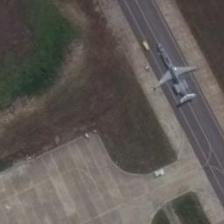

In [35]:
input_image

In [20]:
def generate_caption(model, processor, input_text, input_image):
    inputs = processor(text=input_text,
                       images=input_image,
                       padding="longest",
                       do_convert_rgb=True,
                       return_tensors="pt").to(device)

    input_ids = inputs["input_ids"].to(device)
    pixel_values = inputs["pixel_values"].to(device)
    input_len = input_ids.shape[1]
    generated = input_ids.clone()
    max_new_tokens = 32

    with torch.no_grad():
        past_key_values = None
        for _ in range(max_new_tokens):
            model_inputs = {"input_ids": generated}
            if past_key_values is not None:
                model_inputs["past_key_values"] = past_key_values
            if generated.shape[1] == input_len:  # Only pass pixel_values on first step
                model_inputs["pixel_values"] = pixel_values
            out = model(**model_inputs)
            next_token = out.logits[:, -1, :].argmax(dim=-1, keepdim=True)
            generated = torch.cat([generated, next_token], dim=1)
            past_key_values = out.past_key_values
            if next_token.item() == processor.tokenizer.eos_token_id:
                break
        # Decode generated tokens (skip input prompt)
        caption_ids = generated[0, input_len:]
        caption = processor.decode(caption_ids, skip_special_tokens=True)
        return caption.strip()


In [21]:
!pip install git+https://github.com/salaniz/pycocoevalcap

  Cloning https://github.com/salaniz/pycocoevalcap to /tmp/pip-req-build-43_8k8n8
  Running command git clone --filter=blob:none --quiet https://github.com/salaniz/pycocoevalcap /tmp/pip-req-build-43_8k8n8
  Resolved https://github.com/salaniz/pycocoevalcap to commit a24f74c408c918f1f4ec34e9514bc8a76ce41ffd
  Preparing metadata (setup.py) ... done
  Created wheel for pycocoevalcap: filename=pycocoevalcap-1.2-py3-none-any.whl size=104312245 sha256=0a256f3815d7d8392374bdb492ca099847ee23ccf457dd6113e64d62dd60aae0
  Stored in directory: /tmp/pip-ephem-wheel-cache-8_kj_sw9/wheels/d2/1f/44/6485e566f8ae3d42b56e7c05fd50a3bbb70a50b0e6e7c55212
Successfully built pycocoevalcap


In [22]:
from pycocoevalcap.cider.cider import Cider
from tqdm import tqdm

In [26]:
gts = {}  # ground truths
res = {}  # results

image_dir = "RISCM/resized/"

base_NF4_model.eval()

for idx, example in tqdm(enumerate(dataset['test']), "inference on test test"):
    input_image = PIL.Image.open(image_dir + example["file_name"])
    references = [example['suffix']]  # list of reference captions
    input_text = f"<image> <bos> {example['prefix']}"

    pred_caption = generate_caption(model = base_NF4_model,
                                    processor = processor,
                                    input_text = input_text,
                                    input_image = input_image)
    gts[idx] = references
    res[idx] = [pred_caption]

# Calculate CIDEr
cider_scorer = Cider()
score, scores = cider_scorer.compute_score(gts, res)
print(f"CIDEr score: {score:.4f}")

inference on test test: 4454it [1:54:31,  1.54s/it]


CIDEr score: 1.5533


In [27]:
with open('qvla_captions.txt', 'w') as f:
    print(res, file=f)
f.close()

In [28]:
with open('qvla_gts.txt', 'w') as f:
    print(gts, file=f)
f.close()

In [29]:
base_NF4_model

PaliGemmaForConditionalGeneration(
  (vision_tower): SiglipVisionModel(
    (vision_model): SiglipVisionTransformer(
      (embeddings): SiglipVisionEmbeddings(
        (patch_embedding): Conv2d(3, 1152, kernel_size=(14, 14), stride=(14, 14), padding=valid)
        (position_embedding): Embedding(256, 1152)
      )
      (encoder): SiglipEncoder(
        (layers): ModuleList(
          (0-26): 27 x SiglipEncoderLayer(
            (self_attn): SiglipSdpaAttention(
              (k_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
              (v_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
              (q_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
              (out_proj): Linear4bit(in_features=1152, out_features=1152, bias=True)
            )
            (layer_norm1): LayerNorm((1152,), eps=1e-06, elementwise_affine=True)
            (mlp): SiglipMLP(
              (activation_fn): PytorchGELUTanh()
              (fc1): Li

In [30]:
res[0]

['There is an airplane in the parking lot .']